In [2]:
## Initialize ##
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import scipy.special as scsp
import random as rand
from scipy.optimize import fsolve
import os
from tqdm import tqdm
from class_carbon_gambling import *
from colorsarr import colorsarr #For the colormap
colarr = colorsarr()
carr = colarr.carr
cd = os.getcwd()

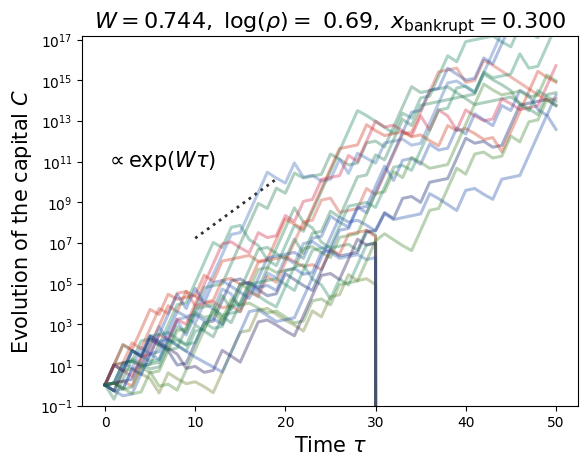

In [3]:
# Example of evolution for a given set of horses
pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
model = kelly_debt(5, 1.05, 1, 30, 1.2, 50, rhoclose=True, pini=pini, rini=rini, rhoini=np.exp(0.69), borroweachstep=True) #Stochastic model
model.plot_evol(int(2E1), scale = 'log') #Plot stochastic evolution

In [4]:
#Compute survival proba from simulations with strategy A#

tplist = [i for i in range(40)] #Time list for survival probability
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
            np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] #List of interest rate values to test
L = 15 #Leverage
cd = os.getcwd()

for i, rho in enumerate(tqdm(rholist)):
    xlist=[]
    xtheolist = []
    for tp in tqdm(tplist):
        count=0 #Count number of times the gambler survives
        counttot=0 #Count total number of simulations
        model = kelly_debt(5, L, 1, tp, 1.2, 50, rhoclose=True, pini=pini, rini=rini, rhoini=rho) #Stochastic model
        for j in range(int(1E4)):
            model.evol()
            count += int(model.C > 0)
            counttot += 1
        x = count/counttot #Survival probability from simulations
        xlist.append(x)
    np.save(cd + r'/data/xlistfast'+str(i)+str(L)+r'.npy', np.array(xlist))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [1:14:47<00:00, 373.95s/it]


100%|██████████| 12/12 [00:00<00:00, 1016.43it/s]


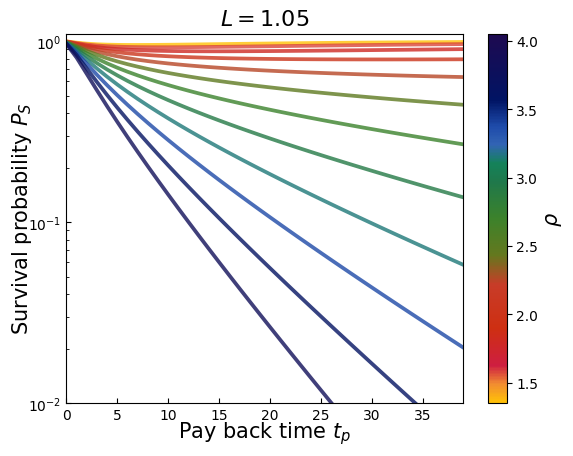

In [5]:
## Gaussian case analytical approximation ##

pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
E1 = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)])) # exp(W)
tplist = [i for i in range(40)] # Time list for survival probability
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
           np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] # List of interest rate values to test
L = 1.05 # Leverage

def survprob(tp, m, sig, L):
    z = (m*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
    return 0.5*(1+scsp.erf(z)) #Analytical value of the survival probability

mlist = [np.log(E1)-np.log(rho) for rho in rholist] # List of m values for each interest rate
sigmalist = [np.sqrt(sum([pini[i]*(np.log(pini[i]/rini[i]/rholist[j]))**2 for i in range(5)]) - (sum([pini[i]*(np.log(pini[i]/rini[i]/rholist[j])) for i in range(5)]))**2) for j in range(len(rholist))] # List of sigma values for each interest rate
cd = os.getcwd()

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-2, fontsize=15)
ax1.set_ylabel(r'Survival probability $P_S$', labelpad=-4, fontsize=15)
ax1.set_title(r'$L={}$'.format(L), fontsize=16)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the color map
norm = mpl.colors.Normalize(vmin=rholist[0], vmax=rholist[-1], clip=False)

for i, m in enumerate(tqdm(mlist)):
    xlist = [survprob(tp+1, m, sigmalist[i], L) for tp in tplist]
    ax1.plot(tplist, xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(mlist)), label=r'$\rho = {}$'.format(str(rho)[:5]))
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$\rho$')
cbar.set_label(r'$\rho$', fontsize=15)
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both') 
ax1.set_yscale('log')
ax1.set_ylim(1E-2, 1.1E0)
fig1.savefig(cd + r'/results/survprob_gaussian'+str(L)+'.pdf')

100%|██████████| 12/12 [00:00<00:00, 783.60it/s]

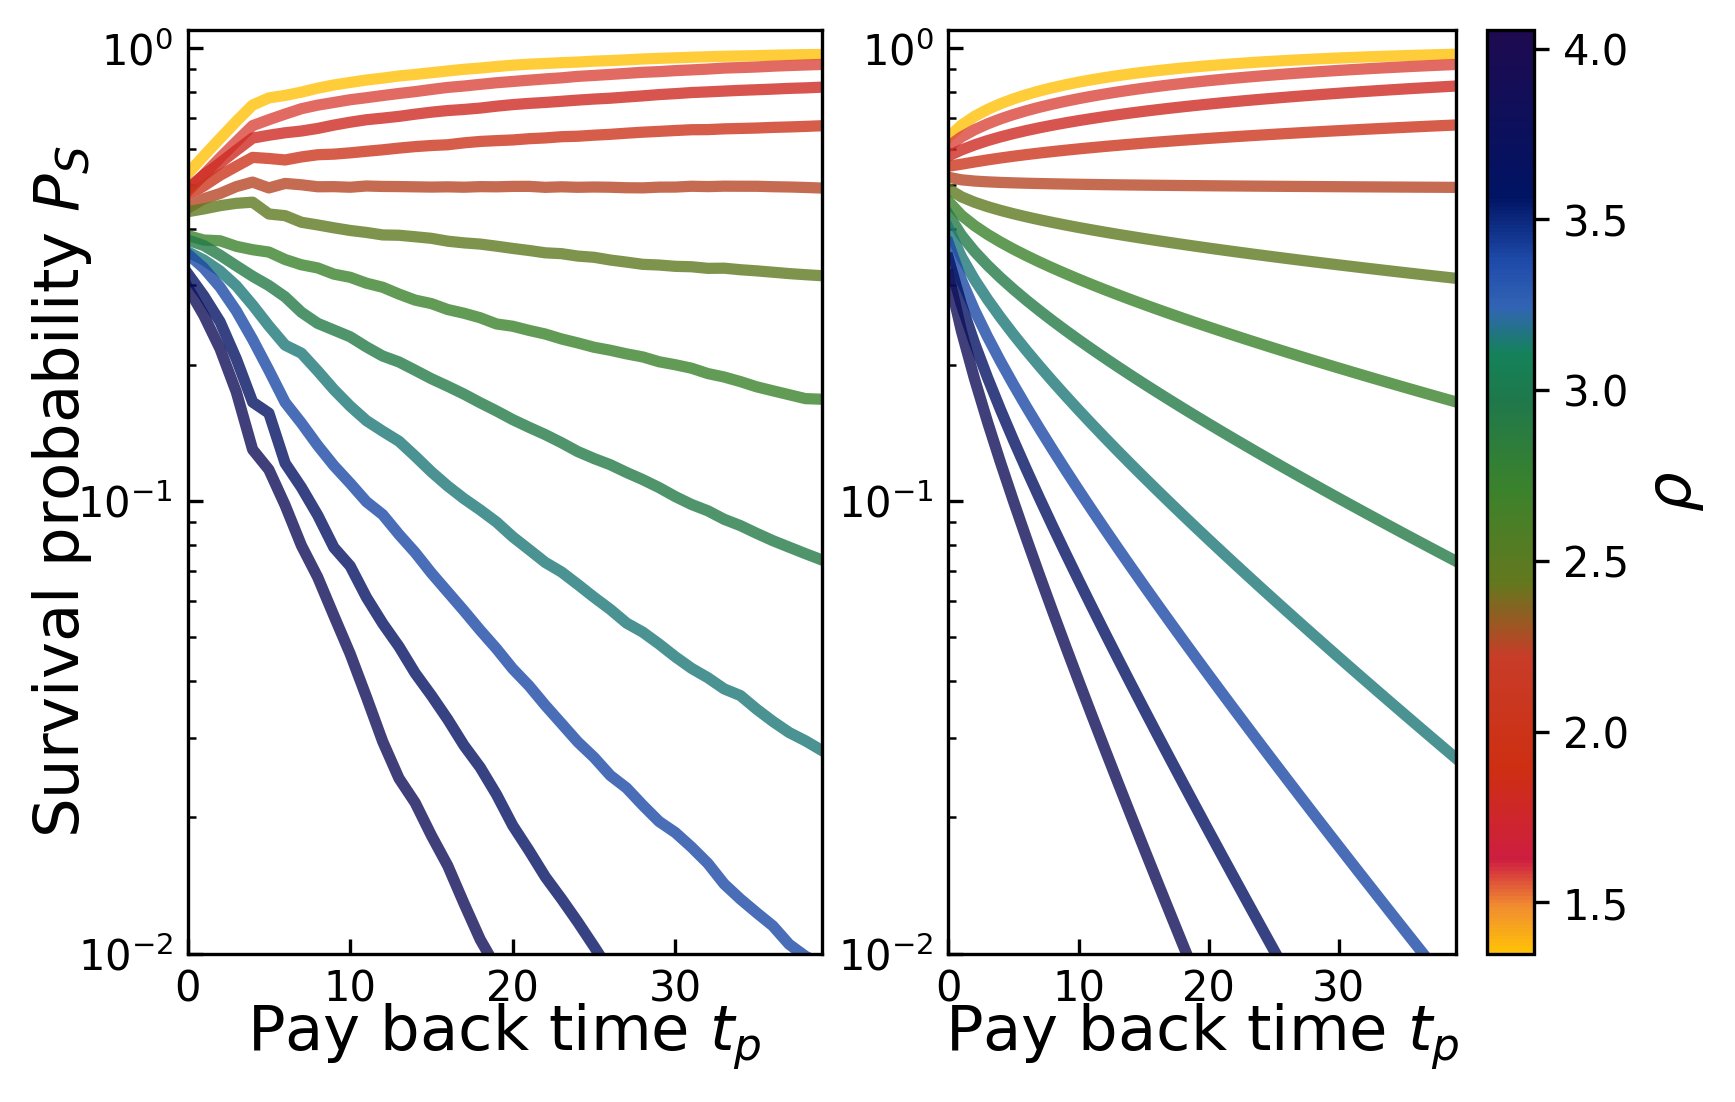

In [9]:
## Plot survival probability from simulations and theory ##
def smoothen(list, nm = 10): # Smoothen the list with a moving average
    reslist = []
    meanlist = [k-nm//2 for k in range(nm)]
    for j in range(len(list)):
        reslist.append((sum([list[min(max(0,j+k),len(list)-1)] for k in meanlist]))/nm)
    return reslist

pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
tplist = [i for i in range(40)] # Time list for survival probability
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
           np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] # List of interest rate values to test
L = 15 # Leverage
cd = os.getcwd()

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=rholist[0], vmax=rholist[-1], clip=False)

fig1 = plt.figure(figsize=(6, 4), dpi=300)
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-2, fontsize=15)
ax1.set_ylabel(r'Survival probability $P_S$', labelpad=-4, fontsize=15)
ax2.set_xlabel(r'Pay back time $t_p$', labelpad=-2, fontsize=15)

for i, rho in enumerate(tqdm(rholist)):
    xlist = np.load(cd + r'/data/xlistfast'+str(i)+str(L)+r'.npy')
    xlist = smoothen(xlist, nm=7)
    ax1.plot(tplist, xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(rholist)), label=r'$\rho = {}$'.format(str(rho)[:5]))

for i, m in enumerate(tqdm(mlist)):
    xlist = [survprob(tp+1, m, sigmalist[i], L) for tp in tplist]
    ax2.plot(tplist, xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(mlist)), label=r'$\rho = {}$'.format(str(rho)[:5]))

ax1.margins(x=0)
ax1.tick_params(direction='in', which='both') 
ax1.set_yscale('log')
ax1.set_ylim(1E-2, 1.1E0)

cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax2, label=r'$\rho$')
cbar.set_label(r'$\rho$', fontsize=15)
ax2.margins(x=0)
ax2.tick_params(direction='in', which='both') 
ax2.set_yscale('log')
ax2.set_ylim(1E-2, 1.1E0)
fig1.savefig(cd + r'/results/survprob_stratA'+str(L)+'.pdf')

In [ ]:
## Survival probability for strategy B from simulations ##

rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
           np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] # List of interest rate values to test
L = 1.05 # Leverage
cd = os.getcwd()

for i, rho in enumerate(tqdm(rholist)):
    model = kelly_debt(5, L, 1., tplist[-1], rho, 100, rhoclose=True, pini=pini, rini=rini, rhoini=rho, gaussian=True, W = np.log(2.003), sig=1.325, borroweachstep=True) # Stochastic model
    xlist = model.survprob(tfin=40)
    np.save(cd + r'/data/xlistfast_stratB'+str(i)+str(L)+r'.npy', np.array(xlist))

100%|██████████| 12/12 [00:00<00:00, 303.26it/s]


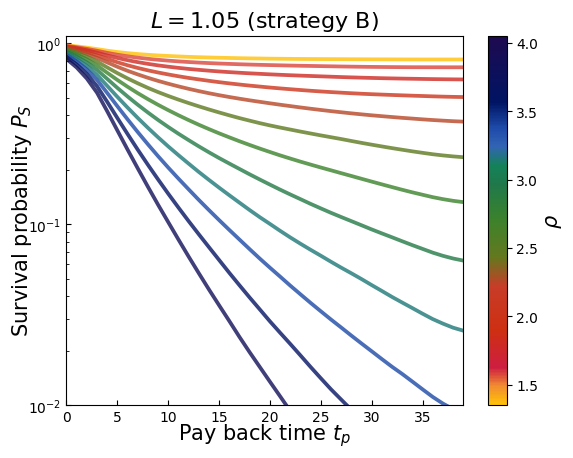

In [10]:
## Plot survival probability for strategy B from simulations ##

def smoothen(list, nm = 10): # Smoothen the list with a moving average
    reslist = []
    meanlist = [k-nm//2 for k in range(nm)]
    for j in range(len(list)):
        reslist.append((sum([list[min(max(0,j+k),len(list)-1)] for k in meanlist]))/nm)
    return reslist

tplist = [i for i in range(40)] # Time list for survival probability
rholist = [np.exp(0.3), np.exp(0.4), np.exp(0.5), np.exp(0.6),
           np.exp(0.7), np.exp(0.8), np.exp(0.9), np.exp(1.), np.exp(1.1), np.exp(1.2), np.exp(1.3), np.exp(1.4)] # List of interest rate values to test
L = 1.05 # Leverage
cd = os.getcwd()

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-2, fontsize=15)
ax1.set_ylabel(r'Survival probability $P_S$', labelpad=-4, fontsize=15)
ax1.set_title(r'$L={}$ (strategy B)'.format(L), fontsize=16)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=rholist[0], vmax=rholist[-1], clip=False)

for i, rho in enumerate(tqdm(rholist)):
    xlist = np.load(cd + r'/data/xlistfast_stratB'+str(i)+str(L)+r'.npy')
    xlist = smoothen(xlist, nm=7)
    ax1.plot(tplist, xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(rholist)), label=r'$\rho = {}$'.format(str(rho)[:5]))
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$\rho$')
cbar.set_label(r'$\rho$', size=15)
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both') 
ax1.set_yscale('log')
ax1.set_ylim(1E-2, 1.1E0)
fig1.savefig(cd + r'/results/survprob_kelly_stratB'+str(L)+'.pdf')

In [ ]:
## Infuence of Leverage on survival probability for strategy B#

Larr = np.linspace((1.001), (1.2), 100)

## Gaussian case ##
import scipy.special as scsp
pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
E1 = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)])) # exp(W)
tplist = np.linspace(0,20,21) # Time list for survival probability
rho = 1.75 # Interest rate

m = np.log(E1)-np.log(rho)
sig = np.sqrt(sum([pini[i]*(np.log(pini[i]/rini[i]/rho))**2 for i in range(5)]) - (sum([pini[i]*(np.log(pini[i]/rini[i]/rho)) for i in range(5)]))**2)
cd = os.getcwd()

PSlist = []
for i, L in enumerate(tqdm(Larr)):
    PSlisty=[]
    for tp in tplist:
        count=0 # Count number of times the gambler survives
        counttot=0 # Count total number of simulations
        model = kelly_debt(5, L, 1., tp, rho, 50, rhoclose=True, pini=pini, rini=rini, rhoini=rho, gaussian=True, W = np.log(E1), sig=sig, borroweachstep=True) # Stochastic model
        for j in range(int(1E4)):
            model.evol()
            count += int(model.C > 0) # Count if the gambler survives
            counttot += 1
        x = count/counttot # Survival probability from simulations
        PSlisty.append(x) 
    PSlist.append(PSlisty)
np.save(cd + r'/data/PSlistfast_stratB'+str(i)+str(rho)+r'.npy', np.array(PSlist))

In [ ]:
## Plot survival probability for strategy B from simulations and the influence of leverage ##

rho = 1.75 # Interest rate

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=15)
ax1.set_ylabel(r'Leverage $L$', labelpad=-2, fontsize=15)
ax1.set_title(r'$\rho={}$'.format(rho), fontsize=16)

clist = carr[:13].copy()
clist.reverse()
clist = [(0, clist[0]), (0.1, clist[1]), (0.22, clist[2]), (0.3, clist[3]), (0.4, clist[4]), (0.45, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=0., vmax=1., clip=False)

PSlist = np.load(cd + r'/data/PSlistfast_stratB'+str(i)+str(rho)+r'.npy')
X, Y = np.meshgrid(tplist, Larr)
ax1.pcolormesh(X, Y, PSlist, cmap=cmapphase, norm=norm, shading='gouraud', alpha=0.9, lw=0.5)

cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$\ln(L)$')
cbar.set_label(r'$P_S$', fontsize=15)
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + r'/results/survprob_gaussian_difL'+str(rho)+'.pdf')


/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_2242/2211991857.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  return (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp)) if np.exp(tp*lnE) > (1.-1./L)*(rho**tp) else -1000 #Analytical value of the short term growth rate


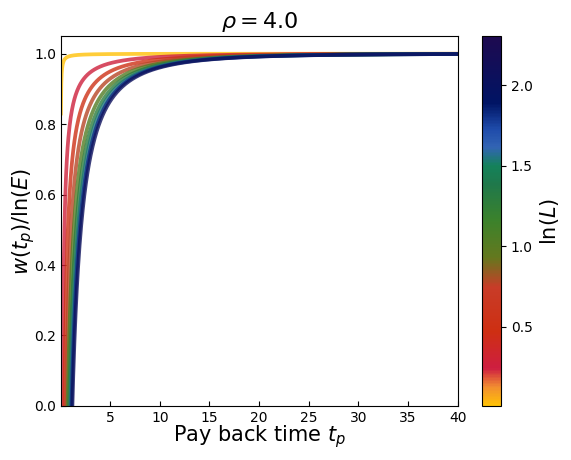

In [11]:
## Infuence of Leverage on short term growth rate #

Larr = np.logspace(np.log10(1.01), np.log10(10), 9)

## Gaussian case ##
pini=[0.03, 0.20, 0.39, 0.12, 0.26]
rini=[0.15, 0.39, 0.04, 0.21, 0.21]
expW = np.exp(sum([pini[i]*np.log(pini[i]/rini[i]) for i in range(5)])) # exp(W)
E2 = sum([pini[i]*pini[i]/rini[i] for i in range(5)]) # Expected value of the strategy
tplist = np.linspace(0,40,int(1E3)) # Time list for survival probability
rho = 4. # Interest rate

def wt(tp, E, rho, L):
    lnE = np.log(E)
    return (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp)) if np.exp(tp*lnE) > (1.-1./L)*(rho**tp) else -1000 #Analytical value of the short term growth rate

cd = os.getcwd()

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_xlabel(r'Pay back time $t_p$', labelpad=-1, fontsize=15)
ax1.set_ylabel(r'$w(t_p)/\ln(E)$', labelpad=-2, fontsize=15)
ax1.set_title(r'$\rho={}$'.format(rho), fontsize=16)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) # Create the color map
norm = mpl.colors.Normalize(vmin=np.log(Larr[0]), vmax=np.log(Larr[-1]), clip=False)

for i, L in enumerate(Larr):
    xlist = [wt(tp, E2, rho, L)/np.log(E2) for tp in tplist]
    ax1.plot(tplist, xlist, lw = 2.7, alpha = 0.8, c=cmapphase(i/len(Larr)), label=r'$L = {}$'.format(str(L)[:5]))
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$\ln(L)$')
cbar.set_label(r'$\ln(L)$', fontsize=15)
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both')
ax1.set_ylim(0., 1.05)
fig1.savefig(cd + r'/results/wtp_difL'+str(rho)+'.pdf')

/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_2242/277296911.py:56: RuntimeWarning: divide by zero encountered in log
  lnrho = np.log(rho) #Logarithm of the interest rate
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_2242/277296911.py:71: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(WPslist, siglist, c=carr[int(2*n)], alpha=0.2, s=15, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 0)
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_2242/277296911.py:72: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please us

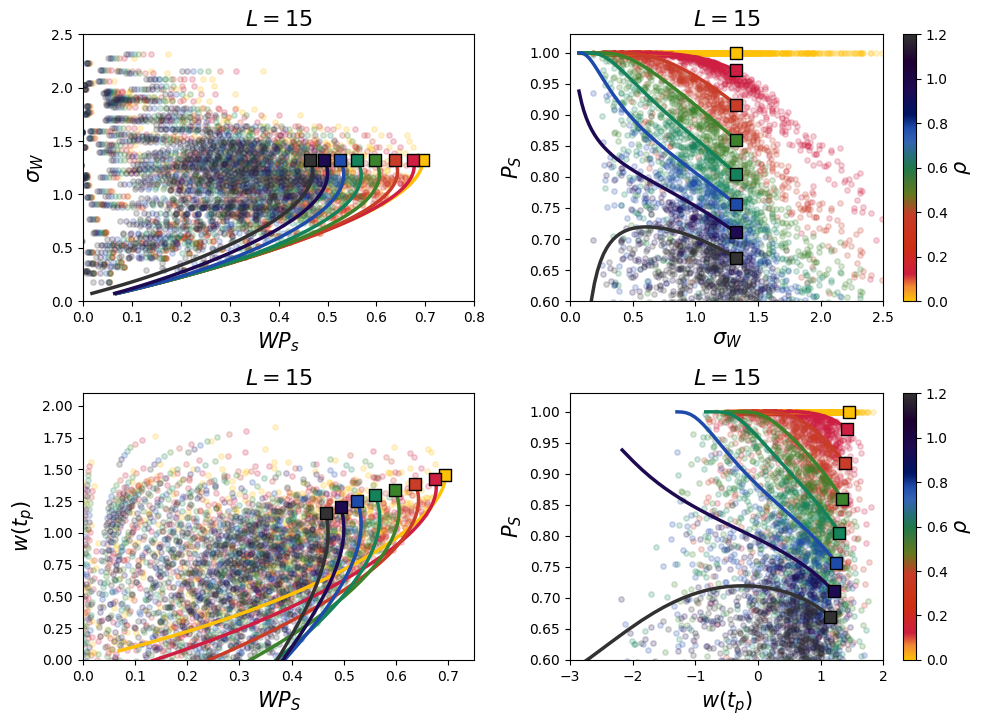

In [21]:
## Tradeoff branches for the different parameters ##

def random_discrete_distribution(n):
    # Generate n random numbers
    random_numbers = np.random.rand(n)
    
    # Normalize the numbers so they sum to 1
    distribution = random_numbers / np.sum(random_numbers)
    
    return distribution

def fixed_point_iteration(f, x0, tol=1E-3, max_iter=int(1E3)):
    """
    Solve x = f(x) using fixed-point iteration.
    
    Parameters:
    - f: function that takes a vector x and returns a vector of same dimension
    - x0: initial guess (numpy array)
    - tol: tolerance for convergence
    - max_iter: maximum number of iterations
    
    Returns:
    - The fixed point x satisfying x ≈ f(x)
    """
    x = x0.copy()
    for i in range(max_iter):
        x_new = f(x)
        if np.linalg.norm(x_new - x) < tol:
            return x_new
        x = x_new
    return np.array([])

# First, we fix p and r #
px=[0.03, 0.20, 0.39, 0.12, 0.26] # Probabilities of the horses
rx=[0.15, 0.39, 0.04, 0.21, 0.21] # Returns of the horses
L = 15 # Leverage

# Then we vary b #
precision = 700
rholist = np.linspace(0.,1.2,8) # Interest rate values to test
xlist = [1.-t for t in np.linspace(0.0001, 0.9999, precision)]
bxlist = [random_discrete_distribution(5) for x in range(precision)]

fig1 = plt.figure(figsize=(10, 8))
ax1, ax2, ax3, ax4 = fig1.add_subplot(221), fig1.add_subplot(222), fig1.add_subplot(223), fig1.add_subplot(224)
cd = os.getcwd()

tp=1.

for n, rho in enumerate(rholist): #For different interest rates
    wtplist = [] #Intitate short term growth rate list
    Pslist = [] #Initiate survival probability list
    Wlist = [] #Initiate W list
    siglist = [] #Initiate sigma list
    lnElist = [] #Initiate lnE list
    lnrho = np.log(rho) #Logarithm of the interest rate
    for m, bx in enumerate(bxlist):
        Wsol = sum([px[i]*np.log(bx[i]/rx[i]) for i in range(len(px))]) # W average of gamma
        lnE = np.log(sum([px[i]*(bx[i]/rx[i]) for i in range(len(px))])) # lnE
        sig = np.sqrt(sum([px[i]*(np.log(bx[i]/rx[i]))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(bx[i]/rx[i])) for i in range(len(px))]))**2) # Standard deviation of gamma
        mean = Wsol - lnrho
        wtp = (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp)) # Short term growth rate
        z = (mean*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
        Psurv = 0.5*(1+scsp.erf(z)) # Survival probability
        wtplist.append(wtp)
        Pslist.append(Psurv)
        Wlist.append(Wsol)
        lnElist.append(lnE)
        siglist.append(sig)
    WPslist = [Wlist[i]*Pslist[i] for i in range(len(Wlist))]
    ax1.scatter(WPslist, siglist, c=carr[int(2*n)], alpha=0.2, s=15, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 0)
    ax2.scatter(siglist, Pslist, c=carr[int(2*n)], alpha=0.2, s=15, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 0)
    ax3.scatter(WPslist, wtplist, c=carr[int(2*n)], alpha=0.2, s=15, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 0)
    ax4.scatter(wtplist, Pslist, c=carr[int(2*n)], alpha=0.2, s=15, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 0)

    ## Kelly's strategy ## Corresponds to b = p
    bx = px
    Wsol = sum([px[i]*np.log(bx[i]/rx[i]) for i in range(len(px))])
    lnE = np.log(sum([px[i]*(bx[i]/rx[i]) for i in range(len(px))]))
    sig = np.sqrt(sum([px[i]*(np.log(bx[i]/rx[i]))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(bx[i]/rx[i])) for i in range(len(px))]))**2)
    wtp = (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp))
    mean = Wsol - lnrho
    z = (mean*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
    Psurv = 0.5*(1+scsp.erf(z))
    ax1.scatter(Wsol*Psurv, sig, c=carr[int(2*n)], alpha=1., s=80, marker='s', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 3)
    ax2.scatter(sig, Psurv, c=carr[int(2*n)], alpha=1., s=80, marker='s', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 3)
    ax3.scatter(Wsol*Psurv, wtp, c=carr[int(2*n)], alpha=1., s=80, marker='s', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 3)
    ax4.scatter(wtp, Psurv, c=carr[int(2*n)], alpha=1., s=80, marker='s', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 3)
    
    ## Safe strategy ##
    alphalist = np.linspace(0,0.48, int(1.E2))
    safeWPS = []
    safesig = []
    safewtp = []
    safePS = []
    safelnE = []
    safeW = []
    bx = np.array(px.copy())
    for alpha in alphalist:
        def f_solve(b):
            Wsol = sum([px[i]*np.log(b[i]/rx[i]) for i in range(len(px))])
            lnE = np.log(sum([px[i]*(b[i]/rx[i]) for i in range(len(px))]))
            sigWsol = np.sqrt(sum([px[i]*(np.log(b[i]/rx[i]))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(b[i]/rx[i])) for i in range(len(px))]))**2)
            num = [alpha * (np.log(b[i]/rx[i]) - Wsol) / sigWsol for i in range(len(px))]
            denom = 1 - alpha
            return np.array([min(max(px[i] * (1 - num[i] / denom ),0.),1.) for i in range(len(px))])
        b0 = np.array(bx.copy())
        bsol = fixed_point_iteration(f_solve, b0, tol=1E-2)
        if bsol.size<=0.:
            bsol = fixed_point_iteration(f_solve, b0, tol=6.E-1)
        bx = [b for b in bsol]
        Wsol = sum([px[i]*np.log(bx[i]/rx[i]) for i in range(len(px))])
        lnE = np.log(sum([px[i]*(bx[i]/rx[i]) for i in range(len(px))]))
        sig = np.sqrt(sum([px[i]*(np.log(bx[i]/rx[i]))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(bx[i]/rx[i])) for i in range(len(px))]))**2)
        wtp = (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp))
        mean = Wsol - lnrho
        z = (mean*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
        Psurv = 0.5*(1+scsp.erf(z))
        safeWPS.append(Wsol*Psurv)
        safesig.append(sig)
        safewtp.append(wtp)
        safePS.append(Psurv)
        safeW.append(Wsol)
        safelnE.append(lnE)
    ax1.plot(safeWPS, safesig, c=carr[int(2*n)], alpha=1., zorder=2, lw=2.5, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]))#, s=80, marker='d', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 2)
    ax2.plot(safesig, safePS, c=carr[int(2*n)], alpha=1., zorder=2, lw=2.5, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]))#, s=80, marker='d', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 2)
    ax3.plot(safeWPS, safewtp, c=carr[int(2*n)], alpha=1., zorder=2, lw=2.5, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]))#, s=80, marker='d', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]), zorder = 2)
    ax4.plot(safewtp, safePS, c=carr[int(2*n)], alpha=1., zorder=2, lw=2.5, label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4]))#, s=80, marker='d', edgecolors='black', label=r'$\rho = {}$'.format(str(np.exp(lnrho))[:4], zorder = 2))

clist = carr[:15].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[7]), (0.6, clist[9]), (0.65, clist[10]), (0.7, clist[11]), (0.8, clist[12]), (0.9, clist[13]), (1., clist[14])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist)
norm = mpl.colors.Normalize(vmin=rholist[0], vmax=rholist[-1], clip=False)

ax1.set_xlabel(r'$WP_s$', fontsize=15)
ax1.set_ylabel(r'$\sigma_W$', fontsize=15)
ax1.set_title(r'$L={}$'.format(L), fontsize=16)
fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax2).set_label(label=r'$\rho$', size=15,weight='bold')
fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax4).set_label(label=r'$\rho$', size=15,weight='bold')
ax1.set_xlim(-0.,0.8)
ax1.set_ylim(0.,2.5)

#ax2.legend()
ax2.set_xlabel(r'$\sigma_W$', fontsize=15)
ax2.set_ylabel(r'$P_S$', fontsize=15)
ax2.set_title(r'$L={}$'.format(L), fontsize=16)
ax2.set_xlim(0.,2.5)
ax2.set_ylim(0.6,1.03)

ax3.set_xlabel(r'$WP_S$', fontsize=15)
ax3.set_ylabel(r'$w(t_p)$', fontsize=15)
ax3.set_title(r'$L={}$'.format(L), fontsize=16)
ax3.set_xlim(-0.,0.75)
ax3.set_ylim(0.,2.1)

ax4.set_xlabel(r'$w(t_p)$', fontsize=15)
ax4.set_ylabel(r'$P_S$', fontsize=15)
ax4.set_title(r'$L={}$'.format(L), fontsize=16)
ax4.set_xlim(-3.,2.)
ax4.set_ylim(0.6,1.03)

# Adjust layout to prevent overlapping
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the title

fig1.savefig(cd + '/results/tradeoffs'+str(L)+'.pdf')

In [ ]:
## 3D plot ##
def fixed_point_iteration(f, x0, tol=1e-4, max_iter=int(1E8)):
    """
    Solve x = f(x) using fixed-point iteration.
    
    Parameters:
    - f: function that takes a vector x and returns a vector of same dimension
    - x0: initial guess (numpy array)
    - tol: tolerance for convergence
    - max_iter: maximum number of iterations
    
    Returns:
    - The fixed point x satisfying x ≈ f(x)
    """
    x = x0.copy()
    for i in range(max_iter):
        x_new = f(x)
        if np.linalg.norm(x_new - x) < tol:
            return x_new
        x = x_new
    raise RuntimeError(f"Failed to converge in {max_iter} iterations")

cmap_name = 'phasecolors'
n_bins = []
px1=[0.03, 0.20, 0.39, 0.12, 0.26]
rx1=[0.15, 0.39, 0.04, 0.21, 0.21]
W1 = sum([px1[i]*np.log(px1[i]/rx1[i]) for i in range(len(px1))]) #Value of W
lnE1 = np.log(sum([px1[i]*(px1[i]/rx1[i]) for i in range(len(px1))])) #Value of lnE
x=0.8
px2=[0.03*x + 0.19*(1-x), 0.20*x + 0.30*(1-x), 0.39*x + 0.19*(1-x), 0.12*x + 0.1*(1-x), 0.26*x + 0.22*(1-x)]
rx2 = [0.15*x + 0.1*(1-x), 0.39*x + 0.24*(1-x), 0.04*x + 0.23*(1-x), 0.21*x + 0.16*(1-x), 0.21*x + 0.18*(1-x)]
W2 = sum([px2[i]*np.log(px2[i]/rx2[i]) for i in range(len(px2))])
lnE2 = np.log(sum([px2[i]*(px2[i]/rx2[i]) for i in range(len(px2))]))
L = 15

def opti(beta, px, rx, rho,tp, L, strat='kelly', alpha1=0.75):
    if strat=='kelly':
        bx = px
    else:
        def f_solve(b):
            Wsol = sum([px[i]*np.log(b[i]/rx[i]) for i in range(len(px))])
            sigsol = np.sqrt(sum([px[i]*(np.log(b[i]/rx[i]/rho))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(b[i]/rx[i]/rho)) for i in range(len(px))]))**2)
            return np.array([px[i] * (1 + (1-alpha1) * (np.log(b[i]/rx[i]) - Wsol) / sigsol / alpha1 ) for i in range(len(px))])
        b0 = np.array(px.copy())
        bsol = fixed_point_iteration(f_solve, b0)
        bx = [b for b in bsol]
    W = sum([px[i]*np.log(bx[i]/rx[i]) for i in range(len(px))])
    lnE = np.log(sum([px[i]*(bx[i]/rx[i]) for i in range(len(px))]))
    sig = np.sqrt(sum([px[i]*(np.log(bx[i]/rx[i]/rho))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(bx[i]/rx[i]/rho)) for i in range(len(px))]))**2)
    m = W - np.log(rho)
    z = (m*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
    wtp = (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp)) if np.exp(tp*lnE) > (1.-1./L)*(rho**tp) else 0.
    return max(beta*wtp/lnE+0.5*(1-beta)*(1+scsp.erf(z)), 0.), lnE, W, m, sig

alpha1 = 0.75
beta = .01
strat = 'kelly' #Pick strategy between 'kelly' and 'safe'

precision = 750
lnrholist = np.linspace(-.5, 1.5, precision) # Logarithm of the interest rate values to test
tplist = np.linspace(2,3.E1, precision) # Time list for survival probability

minlog = -1
J1list = []
J2list = []
bnds =[(0, 5E2)]
for tp in tplist:
    #print(tp)
    J1y = []
    J2y = []
    for lnrho in lnrholist:
        J1 = opti(beta, px1, rx1, np.exp(lnrho), tp, L, strat=strat, alpha1=alpha1)[0]
        J1y.append(J1)
        J2 = opti(beta, px2, rx2, np.exp(lnrho), tp, L, strat=strat, alpha1=alpha1)[0]
        J2y.append(J2)
    J1list.append(J1y)
    J2list.append(J2y)

data1 = np.array(J1list)
data2 = np.array(J2list)
X, Y = np.meshgrid(lnrholist, tplist)

Z1 = data1
Z2 = data2

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

clist1 = carr[:7].copy()
clist1.reverse()
cmapphase1 = LinearSegmentedColormap.from_list('cmap1', clist1)
clist2 = carr[6:14].copy()
clist2.reverse()
cmapphase2 = LinearSegmentedColormap.from_list('cmap1', clist2)

# Create surface plot
surf1 = ax.plot_surface(X, Y, Z1, cmap=cmapphase1, linewidth=1., rstride=10, cstride=10, alpha=0.65, vmin=0, vmax=1)#, vmin = -100, vmax = 300)

surf2 = ax.plot_surface(X, Y, Z2, cmap=cmapphase2, linewidth=1., rstride=10, cstride=10, alpha=0.8, vmin=0, vmax=1)#, vmin = -100, vmax = 300)

# Add color bar
cbar1 = fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, label=r'$\ln(E) = {}$'.format(str(lnE1)[:4]), pad=0.08)
cbar2 = fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=10, label=r'$\ln(E) = {}$'.format(str(lnE2)[:4]), pad=-0.01, location='left')
cbar1.set_label(r'$\ln(E) = {}$'.format(str(lnE1)[:4]), fontsize=15)
cbar2.set_label(r'$\ln(E) = {}$'.format(str(lnE2)[:4]), fontsize=15)

# Set labels and title
ax.set_xlabel(r'$\ln(\rho)$', fontsize=15)
ax.set_ylabel(r'$t_p$', fontsize=15)
ax.set_zlabel(r'$J_2(\beta={},\rho, t_p)$'.format(beta), fontsize=15)
ax.set_title(r'$L={}$'.format(L), fontsize=18)
ax.set_zlim(0.,1)

# Adjust viewing angle
ax.view_init(elev=18, azim=305)

cd = os.getcwd()
plt.savefig(cd+'/results/3Dlandscape_opti_time'+strat+str(L)+'.pdf')
plt.tight_layout()
plt.show()

In [ ]:
## Phase diag ##

def fixed_point_iteration(f, x0, tol=2e-3, max_iter=int(1E3)):
    """
    Solve x = f(x) using fixed-point iteration.
    
    Parameters:
    - f: function that takes a vector x and returns a vector of same dimension
    - x0: initial guess (numpy array)
    - tol: tolerance for convergence
    - max_iter: maximum number of iterations
    
    Returns:
    - The fixed point x satisfying x ≈ f(x)
    """
    x = x0.copy()
    for i in range(max_iter):
        x_new = f(x)
        if np.linalg.norm(x_new - x) < tol:
            return x_new
        x = x_new
    return x_new
    raise RuntimeError(f"Failed to converge in {max_iter} iterations")


cmap_name = 'phasecolors'
n_bins = []

px=[0.03, 0.20, 0.39, 0.12, 0.26]
rx=[0.15, 0.39, 0.04, 0.21, 0.21]
L = 2. # Leverage

def opti(px, rx, rho, tp, L, beta = 5E-2, bx=px): #Optimization function for the trade off between short term growth rate and survival probability
    W = sum([px[i]*np.log(bx[i]/rx[i]) for i in range(len(px))])
    lnE = np.log(sum([px[i]*(bx[i]/rx[i]) for i in range(len(px))]))
    sig = np.sqrt(sum([px[i]*(np.log(bx[i]/rx[i]))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(bx[i]/rx[i])) for i in range(len(px))]))**2) #standard dev for the distrib of jumps
    wtp = (1./tp) * np.log(np.exp(tp*lnE) - (1.-1./L)*(rho**tp)) if np.exp(tp*lnE) > (1.-1./L)*(rho**tp) else 0.
    m = W - np.log(rho)
    z = (m*tp - np.log(1-1/L))/(np.sqrt(2*tp)*sig)
    return beta*wtp/lnE+0.5*(1-beta)*(1+scsp.erf(z)), lnE, W, m, sig, 0.5*(1+scsp.erf(z))

strat='safe' # Pick strategy between 'kelly' and 'safe'

precision = 550
lnrholist = np.linspace(0.,1.,precision)
xlist = [t for t in np.linspace(0.0001, 0.99, precision)]
pxlist=[[0.03*x + 0.2*(1-x), 0.20*x + 0.2*(1-x), 0.39*x + 0.2*(1-x), 0.12*x + 0.2*(1-x), 0.26*x + 0.2*(1-x)] for x in xlist]
rxlist = [[0.15*x + 0.2*(1-x), 0.39*x + 0.2*(1-x), 0.04*x + 0.2*(1-x), 0.21*x + 0.2*(1-x), 0.21*x + 0.2*(1-x)] for x in xlist]
lnElist = []
lnElistbis = []
Wlist = []
bnds =[(0, 8.E1)]

tplist = []
mlist = []
siglist = []
Wlisttot = []
sigWlist=[]
Psurvlist = []

alpha = 0.26 # Risk aversion parameter
for k, rx in enumerate(tqdm(rxlist)):
    tpy = []
    my = []
    sigy = []
    Wlisty = []
    Psurvy = []
    px = pxlist[k]
    if strat=='kelly': # Kelly's strategy
        bx=px
    else: # Safe strategy
        bx=px
        def f_solve(b):
            Wsol = sum([px[i]*np.log(b[i]/rx[i]) for i in range(len(px))])
            lnE = np.log(sum([px[i]*(b[i]/rx[i]) for i in range(len(px))]))
            sigWsol = np.sqrt(sum([px[i]*(np.log(b[i]/rx[i]))**2 for i in range(len(px))]) - (sum([px[i]*(np.log(b[i]/rx[i])) for i in range(len(px))]))**2)
            num = [alpha * (np.log(b[i]/rx[i]) - Wsol) / sigWsol for i in range(len(px))]
            denom = 1 - alpha
            return np.array([min(max(px[i] * (1 - num[i] / denom ),0.),1.) for i in range(len(px))])
        b0 = np.array(bx.copy())
        bsol = fixed_point_iteration(f_solve, b0, tol=1E-2)
        if bsol.size<=0.:
            bsol = fixed_point_iteration(f_solve, b0, tol=6.E-1)
        bx = [b for b in bsol]
    for lnrho in lnrholist:
        def optitp(tp):
            return -opti(px, rx, np.exp(lnrho), tp, L, bx=bx)[0]
        J, lnE, W, m, sig, Psurv = opti(px, rx, np.exp(lnrho), 1, L, bx=bx)
        tp = sp.optimize.minimize(optitp, (1),  method='SLSQP', bounds = bnds).x[0] #, bounds = bnds)
        my.append(m)
        sigy.append(sig)
        Wlisty.append(W)
        tpy.append(tp)
        Psurvy.append(Psurv)
    lnElist.append(lnE)
    Wlist.append(W)
    mlist.append(my)
    siglist.append(sigy)
    Wlisttot.append(Wlisty)
    tplist.append(tpy)
    Psurvlist.append(Psurvy)

data = np.array(tplist)
X, Y = np.meshgrid(lnrholist, lnElist)

cd = os.getcwd()
np.save(cd + '/data/lnrho'+strat + str(L) +'.npy', X)
np.save(cd + '/data/lnE'+strat + str(L) +'.npy', Y)
np.save(cd + '/data/m'+strat + str(L) +'.npy', mlist)
np.save(cd + '/data/sig'+strat + str(L) +'.npy', siglist)
np.save(cd + '/data/Wtot'+strat + str(L) +'.npy', Wlisttot)
np.save(cd + '/data/W'+strat + str(L) +'.npy', Wlist)
np.save(cd + '/data/Psurv'+strat + str(L) +'.npy', Psurvlist)

In [ ]:
import scipy.special as scsp
import scipy as sp
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

alpha=0.26 # Risk aversion parameter
cd = os.getcwd()
strat = 'kelly' # Pick strategy between 'kelly' and 'safe'
L = 2. # Leverage
X,Y,data = np.load(cd + '/data/lnrho'+strat + str(L) +'.npy'), np.load(cd + '/data/lnE'+strat + str(L) +'.npy'), np.load(cd + '/data/tplist'+strat + str(L) +'.npy')
Wlist, mlist, siglist, Wlisttot = np.load(cd + '/data/W'+strat + str(L) +'.npy'), np.load(cd + '/data/m'+strat + str(L) +'.npy'), np.load(cd + '/data/sig'+strat + str(L) +'.npy'), np.load(cd + '/data/Wtot'+strat + str(L) +'.npy')
lnElist = [y[0] for y in Y]
lnrholist = X[0]
sigmalist = [sig[0] for sig in siglist]

def tp_sol(E, rho, alpha, sigma, W):
    m=W-np.log(rho)
    lnE = np.log(E)
    lnrho = np.log(rho)
    b = ((alpha/(1-alpha))*(2*np.sqrt(2*np.pi)*sigma)/(lnrho-W)*(lnE-lnrho))**2
    a = (lnE-lnrho) - (W-lnrho)/(2*sigma**2)
    tp = min(b/2 - a + np.sqrt((b/2) * (b/2 - 2*a)),b/2 - a - np.sqrt((b/2) * (b/2 - 2*a)))
    return(tp)

th = 3E-1
# Function to check and update a pixel based on its neighbors
def update_pixel(data, i, j):
    rows, cols = data.shape
    value = data[i, j]
    
    # Define the neighbors (8-connected)
    neighbors = []
    for x in range(i-2, i+2):
        for y in range(j-2, j+2):
            if x == i and y == j:
                continue  # Skip the current pixel
            if x >= 0 and x < rows and y >= 0 and y < cols:
                neighbors.append(data[x, y])
    
    # If all neighbors are the same and different from the current pixel
    changed = False
    for k in range(len(neighbors)):
        if (abs(neighbors[k] - value)/neighbors[k]>=th):
            S1 = sum([int(abs(n - neighbors[k])/n<th) for n in neighbors])
            if not(changed) and (len(neighbors) > 0) and (S1>int(len(neighbors)*2/3)):
                changed = True
                return sum(neighbors)/len(neighbors)
    return value

xtitle = r'$\ln(\rho)$'
ytitle = r'$\ln(E)$'
if strat == 'kelly':
    title = r'0ptimal payback time with Kelly'+"'"+'s strategy' +r' ($L = {})$'.format(L)
else:
    title = r'0ptimal payback time with a safe strategy $(\alpha={}, $'.format(alpha) + r'$L = {})$'.format(L)

clist = carr[:13].copy()
clist.reverse()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[7]), (0.6, clist[9]), (0.8, clist[10]), (0.9, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create a colormap from the list of colors

# Create a single figure with four subplots
col1 = (50./255,50./255,50./255,1.)
col2 = (170./255,170./255,170./255,1.)
col3 = (210./255,210./255,210./255,1.)
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 6))  # 2x2 grid of subplots
c = ax1.pcolormesh(X, Y, data, cmap=cmapphase, shading='gouraud', vmin=0.9 if survprob else 0., vmax= 1. if survprob else 8.E1, alpha=0.9)#, norm=mpl.colors.LogNorm(5E-1,2E3))#, vmin=0., vmax=1., shading='gouraud')
cbar = fig1.colorbar(c, ax=ax1, label=r'$t_p$')
cbar.set_label(r'$P_S(t_p)$' if survprob else r'$t_p$', fontsize=15)
ax1.plot(np.sort(Wlist), np.sort(lnElist), c=col1, lw=2.5, label=r'$W$', ls='--', alpha=0.9)
ax1.plot(lnrholist, lnrholist, c=col3, lw=2.5, label=r'$E=\rho$', ls='--', alpha=0.9)
ax1.set_xlabel(xtitle, fontsize=15)
ax1.set_ylabel(ytitle, fontsize=15)
ax1.set_xlim(0,1.)
ax1.set_ylim(0,1.)
fig1.set_size_inches(7., 6.)


if strat=='kelly':
    ax1.text(0.02, .8, r'$W=\ln( \rho )$', c=col1, fontsize=15)
    ax1.text(.55, 0.45, r'$E=\rho$', c=col3, fontsize=15)
else:
    ax1.text(0.02, .8, r'$W=\ln( \rho )$', c=col1, fontsize=15)
    ax1.text(.55, 0.45, r'$E=\rho$', c=col3, fontsize=15)

# Adjust layout to prevent overlapping
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the title


z_proj_x = np.mean(data, axis=0)  # Projection onto x-axis (collapse y)
z_proj_y = np.mean(data, axis=1)  # Projection onto y-axis (collapse x)

# Create axes for projections using make_axes_locatable
divider = make_axes_locatable(ax1)

ax1.set_title(title, fontsize=16, pad=20)
# Adjust layout
plt.tight_layout()
plt.savefig('results/phasediag_' + strat + str(L) +'_optimaltime.pdf')
plt.show()